In [1]:
from IPython.display import display, Latex
from IPython.core.display import HTML
%reset -f
%matplotlib inline
%autosave 300
from matplotlib.pylab import *
from time import clock
from scipy.sparse import  spdiags
from scipy.sparse.linalg import spsolve
from scipy.sparse import lil_matrix, csr_matrix, spdiags

Autosaving every 300 seconds


# Méthode élément fini
On présente la mise en oeuvre des éléments finis $\mathbb P_1$ 2D pour le problème de Robin suivant:
$$
\begin {align}
-\Delta u(x,y)=f(x), \quad (x,y)\in \Omega=]0,L[\times]0,H[,\\
\partial_n u(x,y)+ \alpha(x,y) u(x,y)=b(x,y),\quad (x,y)\in \partial \Omega.\\
\end {align}
$$
où $f$ est donné dans $L^2(\Omega)$, $b$ est donné dans $L^2(\partial \Omega)$ et la fonction $\alpha$ est bien-sûr positive et non dégénérée sur une partie du bord de mesure non nulle pour la mesure du bord, afin d'assurer l'ellipticité de l'opérateur sur l'espace $H^1(\Omega)$. Il convient de vérifier en effet que toutes les hypothèses du théorème de Lax-Milgram sont vérifiées pour la formulation faible:
$$
\left (\mathcal V\right ) \begin {cases}
\text{Trouver } u\in H^1(\Omega)\text{ tel que }\forall v\in H^1(\Omega)\\
\int_{\Omega} \nabla u(x,y)\cdot \nabla v(x,y)\,dxdy+\int_{\partial\Omega}\alpha(x,y)u(x,y)v(x,y)\,d\gamma=\int_{\Omega} f(x)v(x)\,dxdy+\int_{\partial\Omega}b(x,y)v(x,y)\,d\gamma.
\end {cases}
$$
On notera $a(u,v)$ l'expression de la forme bilinéaire intervenant dans le membre de gauche de $\left (\mathcal V\right )$ et on notera $l(v)$ la forme linéaire intervenant dans le membre de droite de $\left (\mathcal V\right )$.
## Formulation faible approchée
On cherche à résoudre le problème approché en dimension finie,
$$
\left (\mathcal V_{l,h}\right ) \begin {cases}
\text{Trouver } u_{l,h}\in V_{l,h}\text{ tel que }\forall v\in V_{l,h}\\
\int_{\Omega} \nabla u_{l,h}(x,y)\cdot \nabla v(x,y)\,dxdy+\int_{\partial\Omega}\alpha(x,y)u_{l,h}(x,y)v(x,y)\,d\gamma=\int_{\Omega} f(x)v(x)\,dxdy+\int_{\partial\Omega}b(x,y)v(x,y)\,d\gamma.
\end {cases}
$$
où $V_{l,h}\subset H^1(\Omega)$ est de dimension finie et 
$$
V_{l,h}=\{ v\in \mathcal C^0(\Omega)\text{ tel que }v_{|T}   \in \mathbb P_1,~\forall T\in \tau_{h,l}\},
$$
avec $\tau_{l,h}$ une triangulation conforme de $\Omega$ où $l$ et $h$ sont les longueurs horizontales et verticales des triangles rectangles $T$ qui recouvrent $\Omega$.On pose $l=\frac L {N-1}$, $h=\frac H {M-1}$ et $(x_i=il,y_j=jh)$ pour $0\le i<N$, $0\le j<M$ sont les sommets de ces triangles. On peut vérifier que  ces $NM$ sommets sont dans $\overline{\Omega}$ et que ces triangles sont au nombre de $2(N-1)(M-1)$ puisque 2 triangles recouvrent un rectangle de la forme $\widehat{\left((x_i,y_j),(x_{i+1},y_j),(x_{i+1},y_{j+1}),(x_i,y_{j+1})\right)}$. Nous avons le choix de couper ce rectangle à l'aide d'une diagonale ou l'autre, ceci revient à changer de maillage. On choisira par exemple la diagonale $((x_i,y_j)(x_{i+1},y_{j+1}))$.
## Base de l'espace d'approximation
On construit une base de $V_{l,h}$ à l'aide des fonctions chapeaux  $\Phi_k$ pour $0\le k<NM$ tel que
$$
\begin {cases}
\Phi_k(S_k)=1,\\
\Phi_k(S_m)=0 \text{ pour }m\neq k\\
S_k=(x_i,y_j), \text{ le kème sommet avec } k=i+j*N,~0\le i<N,~0\le j<M.
\end {cases}
$$
On vérifie aisément que $\{\Phi_k \}_{0\le i< NM}$ forme une famille libre et génératrice de $V_{l,h}$:
$$
\forall v\in V_{l,h},\quad v=\sum_{k=0}^{NM-1}v(S_k)\Phi_k.
$$
## Système linéaire associé à $\left (\mathcal V_{l,h}\right )$
On cherche $u_{l,h}$ qui se décompose sur la base $\{\Phi_k \}_{0\le k< NM}$ de dimension $NM$,
$$
u_{l,h}(x,y)=\sum_{k=0}^{NM-1}u_i\Phi_i(x,y),\quad \forall (x,y)\in \Omega.
$$
On notera que les inconnues $u_k$ (coefficients scalaires dans la base) satisfont $u_k=u_{l,h}(S_k)$, où les $S_k$ sont les points d'une grille régulière, ce qui sera bien pratique pour visualiser la solution sans avoir à reconstruire $u_{l,h}$.

Plutôt que de vérifier $\left (\mathcal V_{l,h}\right )$ pour tout $v\in V_{l,h}$, il suffit de vérifier la formulation variationelle pour tout $\Phi_k$, $0\le k<NM$. On a ainsi $NM$ équations scalaires pour $NM$ inconnues. Soit le système matricielle,
$$
AU=F,\text{ avec }U=(u_0,\cdot,u_{NM-1})^t, ~F=(l(\Phi_0),\cdots,l(\Phi_{NM-1}))^t, \text{ et }A_{ij}=a(\Phi_j,\Phi_i).
$$

## Assemblage de la matrice
La méthode consiste à construire une matrice dite élémentaire qui évalue le calcul intégral de la formulation faible sur un élément fini et l'assemblage de la matrice globale $A$ se fait alors par somme des contributions venant de chaque élément.

On construit la matrice élémentaire $el$ de taille $(3,3)$ en évalauant l'intégration sur un élément $T$ de fonctions de base élémentaires attachées à l'élément,
$$
1\le i\le 3,~1\le j\le 3,~el_{i,j}=
\int_T \nabla \varphi_i(x,y)\cdot \nabla \varphi_j(x,y)\, dx dy.
$$
Le triangle $T$ se définit par 3 sommets de référence $s_1=(0,0)$, $s_2=(l,0)$, $s_3=(h,0)$ et tous les triangles de $\tau_{l,h}$ sont isomorphes à $T$. Par un changement de variable, on se ramènera toujours à ce triangle de référence.

Le gradiant d'un élément de $\mathbb P_1$ étant constant, le calcul de la matrice élémentaire est trivial. On a $\varphi_i(s_j)=\delta_{ij}$, ainsi
$$
\nabla \varphi_1=(-\frac 1 l, -\frac 1 h)^t,
~\nabla \varphi_2=(\frac 1 l, 0)^t,
~\nabla \varphi_3=(0, -\frac 1 h)^t.
$$
La matrice élémentaire est donc
$$
el=\frac {hl} 2\left (
\begin {matrix}
\frac 1 {l^2}+\frac 1 {h^2} &-\frac 1 {l^2}&-\frac 1 {h^2}\\
-\frac 1 {l^2}&\frac 1 {l^2} &0\\
-\frac 1 {h^2}&0&\frac 1 {h^2} 
\end {matrix}\right ).
$$
La clé du remplissage de la matrice globale $A$ repose sur la formule
$$
\int_{\Omega} \nabla \Phi_i(x,y)\cdot \nabla \Phi_j(x,y)\,dxdy=\sum_{T\in \tau_{l,h}}\int_{T} \nabla \Phi_i(x,y)\cdot \nabla \Phi_j(x,y)\,dxdy,
$$
mais aussi sur le fait que sur l'élément $T$ la contribution des termes $\Phi_i$ et $\Phi_j$ est non trivial lorsque ceux-ci sont les fonctions de base attachés aux sommets de $T$. A une translation près puis rotation ou symétrie près pour se ramener à l'élément de référence, ces fonctions non triviales sont les fonctions de base  $\varphi_1$, $\varphi_2$ et $\varphi_3$ de l'élément de référence.
La mise en oeuvre numérique repose alors sur un parcours des éléments, pour chaque élément on va ajouter les contributions de la matrice élémentaire dans les lignes et colonnes apropriées de la matrice. L'inverse serait trop compliqué, en effet, s'il fallait pour un coefficient donné de la matrice identifier tous les éléments qui contribuent à ce coefficient, on ne sortirait plus des cas particuliers et l'extension à un maillage quelconque serait impossible. 

La matrice déduite de la matrice élémentaire proposée est celle de l'opérateur de Neuman, on pourrait alors vérifier que la somme des coefficients par ligne fait $0$ et conclure que $0$ est valeur propre.
    Il reste à ajouter dans la matrice la contribution des termes de bord provenant des conditions limites de type Robin. La méthodologie est la même sauf que l'intégrale sur le bord se décompose en somme d'intégrales de bord joignant deux sommets du bord de la triangulations appartenant au même élément. A faire en exercice.

## Construction du second membre
La construction du second membre nécessite le calcul de 
$$
\int_\Omega f(x,y)\Phi_k(x,y)\,dxdy.
$$
L'autre terme faisant intervenir le bord (condition limite inhomogène) est laissé en exercice.

On se contentera d'une formule de quadrature pour approcher l'intégrale sur $\Omega$. On choisira la triangulation $\tau_{l,h}$ pour construire une formule de Quadrature composite et sur chaque triangle, on choisira la formule de quadrature à $1$ point
$$
\int_\Omega f(x,y)\Phi_k(x,y)\,dxdy=\sum_{T\in \tau_{l,h}}\int_T f(x,y)\Phi_k(x,y)\,dxdy\sim \frac {hl} 2\sum_{T\in \tau_{l,h}}
f(\frac 1 3 (s_1+s_2+ s_3))\Phi_k(\frac 1 3 (s_1+s_2+ s_3)),
$$
où $T=\widehat{(s_1,s_2,s_3)}$.


In [2]:
N=80
M=120
L=4.5
H=3
l=L/(N-1)
h=H/(M-1)
#remplissage de la matrice
#le format  LIL (list de list) permet de remplir 
#les coefficients d'une matrice creuse en accedant à sa position 
#ligne colonne
#A est ici initialisé à la matrice nulle de la taille considérée
A =lil_matrix((N*M, N*M))
#construction de la matrice élémentaire du terme integral
el=l*h*0.5*array([[l**-2+h**-2 ,-l**-2,-h**-2],[-l**-2,l**-2,0],
                  [-h**-2,0,h**-2]])
#Parcours des éléments rectangulaire
for ki in range(N-1):
    for kj in range(M-1):
        #premier triangle (angle droit, voisin horizontal, voisin bertical)
        S=array([ki+kj*N+1,ki+kj*N,ki+kj*N+N+1])
        for i in range(3):
            for j in range(3):
                A[S[i],S[j]]=A[S[i],S[j]]+el[i,j]
        #deuxieme triangle (angle droit, voisin horizontal, voisin bertical)
        S=array([ki+kj*N+N,ki+kj*N+N+1,ki+kj*N])
        for i in range(3):
            for j in range(3):
                A[S[i],S[j]]=A[S[i],S[j]]+el[i,j]
# la matrice A ici construite ne contient que la contribution 
#de l' opérateur de Neuman 
# la matrice a donc une valeur propre nulle associée au vecteur propre
#qui ne contient que des composantes identiques.
#On peut vérifier que la somme des coefficients par ligne fait 0
#
#On va rajouter les termes provenant des CL de Robin sur le bord bas uniquement
a=100#a représente la fonction alpha constante
elb=a*l*array([[1/3,1/6],[1/6,1/3]])
for k in range(N-1):
    S=array([k,k+1])
    for i in range(2):
        for j in range(2):
            A[S[i],S[j]]=A[S[i],S[j]]+elb[i,j]


#construction du second membre
F=zeros(N*M)
#on suppose les CL de Robin homogène
x=linspace(0,L,N)
y=linspace(0,H,M)
#On définit le terme source comme une fonction
def f(x,y):
    return sin(x)*cos(y)
#Parcours des éléments rectangulaires
for ki in range(N-1):
    for kj in range(M-1):
        #premier triangle (angle droit, voisin horizontal, voisin bertical)
        S=array([ki+kj*N+1,ki+kj*N,ki+kj*N+N+1])
        xg=(2*x[ki]+x[ki+1])/3
        yg=(2*y[kj]+y[kj+1])/3
        for i in range(3):
                F[S[i]]=F[S[i]]+h*l/6*f(xg,yg)
        #deuxieme triangle (angle droit, voisin horizontal, voisin bertical)
        S=array([ki+kj*N+N,ki+kj*N+N+1,ki+kj*N])
        xg=(x[ki]+2*x[ki+1])/3
        yg=(y[kj]+2*y[kj+1])/3
        for i in range(3):
                F[S[i]]=F[S[i]]+h*l/6*f(xg,yg)



#conversion en csr (compressed storage row) pour resolution system
A=A.tocsr()
#resolution systeme creux
U=spsolve(A,F)

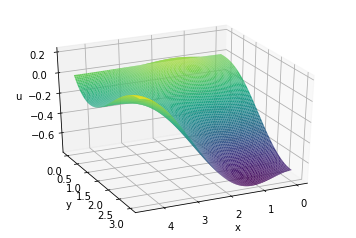

In [3]:
#Visualisation
uu=reshape(U,(M,N))
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
X, Y = meshgrid(x,y)
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, uu, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none');
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('u');
ax.view_init(30, 65)

# Exercices
## Validation
Réaliser une validation de ce code. Il faudra d'abord réécrire sous forme de fonction paramétrée par $N$ et $M$ le calcul de la solution approchée.
## Extension 
Etendre le code au cas des conditions limites de Robin non dégénérées sur tout le bord et inhomogènes.

Valider ce cas général.

Proposition de solution:


On décompose le bord du rectangle en un bord bas (bottom) $\Gamma_b$, un bord haut (top) $\Gamma_t$, un bord gauche (left) $\Gamma_b$, un bord droit (right) $\Gamma_b$.


Nous allons construire la matrice $B=\left (\int_{\partial\Omega} \alpha (\Phi_j(x,y), \Phi_i(x,y)\,d\gamma\right )_{1\le i,j\le NM} $ en parcourant les éléments frontières du bord. Ces éléments sont des segments joignant 2 sommets consécutifs du bord, sommets de la triangulation. Le numéro attribué à chaque sommet est celui de la numérotation globale ($NM$ sommets). La fonction de base $\Phi_i$ attaché au sommet $i$ du bord, restreinte à l'élément de bord est une fonction $\mathbb P_1$ du bord ($\mathbb P_1(x)$ pour les bords bas et haut, $\mathbb P_1(y)$ pour les bords gauche et droit).

Les éléments du bord sont de longueur $l$ (bords horizontaux) et $h$ (bords verticaux). Pour un élément de référence de la forme $[\xi_0,\xi_0+\delta]$, la matrice élémentaire associée à ce terme de Robin est de la forme 
$$
elb=\left ( \int_0^\delta \alpha_*(\xi_0+\xi)\varphi_j(\xi)\varphi_i(\xi)\,d\xi \right )_{1\le i,j\le 2},
$$
avec $\varphi_1(\xi)=\frac {\delta -\xi}{\delta}$, $\varphi_2(\xi)=\frac {\xi}{\delta}$ et $\alpha_*(\xi_0+\xi)$ coïncide avec $\alpha(0,\xi_0+\xi)$ ou $\alpha(L,\xi_0+\xi)$ ou $\alpha(\xi_0+\xi,0)$ ou $\alpha(\xi_0+\xi,H)$ selon le bord considéré.

On trouve, à l'aide d'une formule de quadrature simple, le calcul approché de $elb$,
$$
elb=\alpha_*(\xi_0+\frac {\delta} 2)\delta\left ( \begin {matrix}\frac 1 3& \frac 1 6\\ \frac 1 6& \frac 1 3\end {matrix}\right ).
$$

Nous allons construire également le second membre $SMB$ qui provient des termes de bord inhomogènes:
$$
SMB_i=\int_{\partial\Omega}b(x,y)\Phi_i(x,y)\,d\gamma.
$$
Ce terme est non trivialement nul si le sommet $i$ appartient à $\partial \Omega=\Gamma_b\cup \Gamma_t\cup \Gamma_l\cup \Gamma_r$. 
Pour un élément de référence de la forme $[\xi_0,\xi_0+\delta]$, le vecteur élémentaire associé à ce terme inhomogène est de la forme 
$$
vecb=\left ( \int_0^\delta b_*(\xi_0+\xi)\varphi_i(\xi)\,d\xi \right )_{1\le i\le 2},
$$
avec $\varphi_1(\xi)=\frac {\delta -\xi}{\delta}$, $\varphi_2(\xi)=\frac {\xi}{\delta}$ et $\beta_*(\xi_0+\xi)$ coïncide avec $\beta(0,\xi_0+\xi)$ ou $\beta(L,\xi_0+\xi)$ ou $\beta(\xi_0+\xi,0)$ ou $\beta(\xi_0+\xi,H)$ selon le bord considéré.

On a  alors, à l'aide d'une approximation simple de l'intégrale (qu'on peut améliorer)
$$
vecb=b_*(\xi_0+\frac \delta 2)\frac \delta 2\left ( \begin{matrix} 1\\1\end{matrix}\right ).
$$


In [4]:
#exemple de coeff Robin comme des fonctions
def alpha(x,y):
    return 2+sin(x)*cos(y)
def b(x,y):
    return sin(x)*cos(y)

#  la fonction rendant la matrice et le second membre relatif aux termes Robin
def bord_robin(N,M,L,H):
    l=L/(N-1)
    h=H/(M-1)
    B =lil_matrix((N*M, N*M))
    SMB= zeros(N*M)
    #construction de la matrice élémentaire du terme integral
    elb=array([[1/3 ,1/6],[1/6,1/3]])
    #Parcours des éléments du bas
    for ki in range(N-1):
    #numero des sommets de l'element
        s=array([ki,ki+1])
        for i in range(2):
            for j in range(2):
                B[s[i],s[j]]+=alpha((ki+0.5)*l,0)*l*elb[i,j]
        for i in range(2):
            SMB[s[i]]+=b((ki+0.5)*l,0)*l*0.5
    #Parcours des éléments du haut
    for ki in range(N-1):
        #numero des sommets de l'element
        s=array([ki+N*(M-1),ki+N*(M-1)+1])
        for i in range(2):
            for j in range(2):
                B[s[i],s[j]]+=alpha((ki+0.5)*l,H)*l*elb[i,j]
        for i in range(2):
            SMB[s[i]]+=b((ki+0.5)*l,H)*l*0.5
    #Parcours des éléments du bord gauche
    for kj in range(M-1):
        #numero des sommets de l'element
        s=array([kj*N,kj*N+N])
        for i in range(2):
            for j in range(2):
                B[s[i],s[j]]+=alpha(0,(kj+0.5)*h)*h*elb[i,j]
        for i in range(2):
            SMB[s[i]]+=b(0,(kj+0.5)*h)*h*0.5
    #Parcours des éléments du bord droit
    for kj in range(M-1):
        #numero des sommets de l'element
        s=array([kj*N+N-1,kj*N+2*N-1])
        for i in range(2):
            for j in range(2):
                B[s[i],s[j]]+=alpha(L,(kj+0.5)*h)*h*elb[i,j]
        for i in range(2):
            SMB[s[i]]+=b(L,(kj+0.5)*h)*h*0.5
    return B,SMB
# A vous de poursuivre, comprendre, vérifier...

## Validation Dirichlet
Par un choix pertinent de $\alpha$ et $\beta$, proposer avec le même code une validation pour un problème de Dirichlet inhomogène.
## Elément fini $\mathbb Q_1$
Proposer la construction de l'approximation $\mathbb Q_1$ conforme de Lagrange pour ce même problème de Robin inhomogène. Vérifier l'ordre de la méthode obtenue. 